# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
#from ensemble import RandomForestRegressor
#from model_selection import TimeSeriesSplit

import os
os.chdir("../scripts")
print(os.getcwd())

c:\Users\justi\GitHub\Compet-DSR-one\scripts


In [2]:
import pre_processing as pp
import feature_engineering as fe
import model_evaluation as me
from model_training import Model
import tree_model_training as tm
from model_evaluation import regression_evaluation
import final_predict as fp

## Pre-process data

In [31]:
# Read in data files 
train_features = pd.read_csv('../data/dengue_features_train.csv')
train_target = pd.read_csv('../data/dengue_labels_train.csv')
test_features = pd.read_csv('../data/dengue_features_test.csv')

In [32]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {train_iq.shape}') 
print(f'train_sj shape: {train_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature Engineering

Different Feature engineering recipes below

In [33]:
def feature_recipe1(f:pd.DataFrame) -> pd.DataFrame:
    """Generate Features
    Run this on the train (and later the test) data for each city
    the variable is called xy beause the target is assumed included.
    Args:
        f (pd.DataFrame): Features

    Returns:
        pd.DataFrame: New Features
    """
    xy = fe.cyclical_encode_date(f)
    xy = fe.shift_features(xy, periods=1)
    xy = fe.drop_date(xy)
    return xy

def feature_recipe2(df_iq:pd.DataFrame, df_sj:pd.DataFrame) -> pd.DataFrame:
    """Generate Features
    Run this on the train (and later the test) data for each city
    the variable is called xy beause the target is assumed included.
    Args:
        f (pd.DataFrame): Features

    Returns:
        pd.DataFrame: New Features
    """
    # Add cyclically encoded dates
    xy_iq = fe.cyclical_encode_date(df_iq)
    xy_iq = fe.drop_date(xy_iq)
    xy_iq = fe.add_rolling2(xy_iq, 'iq', fillna=True)
    xy_iq = fe.remove_original_cols(xy_iq) 

    xy_sj = fe.cyclical_encode_date(df_sj)
    xy_sj = fe.drop_date(xy_sj)
    xy_sj = fe.add_rolling2(xy_sj, 'sj', fillna=True)   
    xy_sj = fe.remove_original_cols(xy_sj)
    
    return xy_iq, xy_sj

def feature_recipe3(df_iq:pd.DataFrame, df_sj:pd.DataFrame) -> pd.DataFrame:
    """Generate Features
    Run this on the train (and later the test) data for each city
    the variable is called xy beause the target is assumed included.
    Args:
        f (pd.DataFrame): Features

    Returns:
        pd.DataFrame: New Features
    """
    # Add cyclically encoded dates
    xy_iq = fe.cyclical_encode_date(df_iq)
    xy_iq = fe.drop_date(xy_iq)
    

    xy_sj = fe.cyclical_encode_date(df_sj)
    xy_sj = fe.drop_date(xy_sj)
    

    # test a bunch of rolling average periods
    for p in range(4,26,2):
        recipe = {
            "ndvi_ne": p,
            "ndvi_nw": p,
            "precipitation_amt_mm": p,
            "reanalysis_air_temp_k": p,
            "reanalysis_avg_temp_k": p,
            "reanalysis_dew_point_temp_k": p,
            "reanalysis_max_air_temp_k": p,
            "reanalysis_precip_amt_kg_per_m2": p,
            "reanalysis_relative_humidity_percent": p,
            "reanalysis_sat_precip_amt_mm": p,
            "reanalysis_specific_humidity_g_per_kg": p,
            "reanalysis_tdtr_k": p,
            "station_avg_temp_c": p,
            "station_diur_temp_rng_c": p,
            "station_max_temp_c": p,
            "station_precip_mm": p,
        }
        xy_iq = fe.add_rolling2(xy_iq, recipe=recipe, fillna=True)
        xy_sj = fe.add_rolling2(xy_sj, recipe=recipe, fillna=True)
    
    #xy_iq = fe.remove_original_cols(xy_iq) 
    #xy_sj = fe.remove_original_cols(xy_sj)
    
    return xy_iq, xy_sj

Xy_iq, Xy_sj = feature_recipe3(Xy_iq, Xy_sj)


### Plot selected Features

In [45]:
scaler = MinMaxScaler()
sj_scaled = scaler.fit_transform(Xy_sj)
sj_scaled = pd.DataFrame(columns=Xy_sj.columns, data= sj_scaled, index=Xy_sj.index)
iq_scaled = scaler.fit_transform(Xy_iq)
iq_scaled = pd.DataFrame(columns=Xy_iq.columns, data= iq_scaled, index=Xy_iq.index)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles = ["San Juan", "Iquitos"], 
                    vertical_spacing=0.02)
n_colors = iq_scaled.shape[1]
colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])


for i, c in enumerate(sj_scaled.columns):
    fig.add_trace(go.Scatter(x=sj_scaled.index, 
                             y=sj_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             name=c,
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             showlegend=False,),
                  
                  row=1, col=1)

for i, c in enumerate(iq_scaled.columns):
    fig.add_trace(go.Scatter(x=iq_scaled.index, 
                             y=iq_scaled.loc[:,c],
                             mode='lines', # 'lines' or 'markers'
                             line_color=colors[i],
                             legendgroup=f'group{i}',
                             name=c),
                 row=2, col=1)
fig.show()

In [47]:
#sj_corr_heat = sns.heatmap(sj_scaled.corr())
#plt.title('San Juan Variable Correlations')

### Split data into X and y

In [7]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']

X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']

assert len(X_iq) == len(y_iq)

# Feature Importance
Using Random Forest regression

In [ ]:
from  sklearn.feature_selection import GenericUnivariateSelect
X, y = X_sj, y_sj
transformer = GenericUnivariateSelect()

<Axes: >

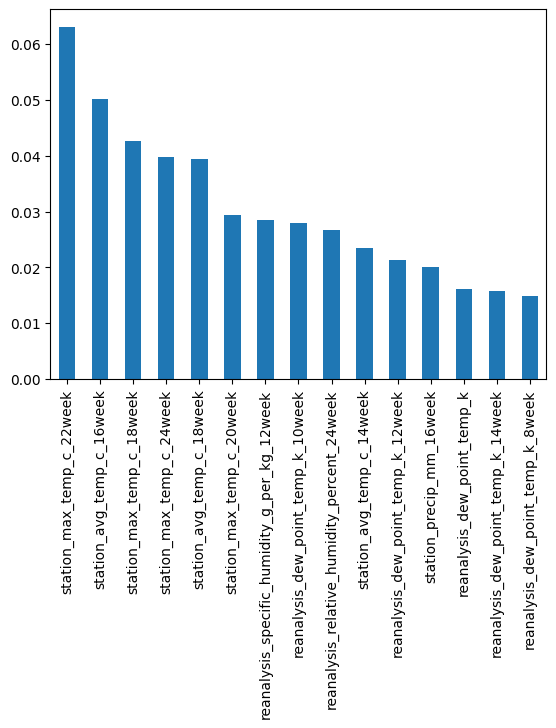

In [51]:
X_sj, y = X_sj, y_sj

scaler = MinMaxScaler()
X_sj_scaled = scaler.fit_transform(X)
X_sj_scaled = pd.DataFrame(columns=X_sj.columns, data= X_sj_scaled, index=X_sj.index)

#iq_scaled = scaler.fit_transform(y)
#iq_scaled = pd.DataFrame(columns=Xy_iq.columns, data= iq_scaled, index=Xy_iq.index)

feature_importances = tm.rf_feature_importance(X_sj_scaled, y)
top_15 = feature_importances.sort_values(ascending=False)[:15]
top_15.plot.bar()

## XGBoost

In [11]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model_noscaling(X, y)

(    TSS iteration  rmse_test  rmse_train  mae_test  mae_train  learning_rate  \
 0               1   8.323657    1.914076  5.984741   1.161488           0.05   
 1               1   8.135087    2.297718  5.674240   1.336767           0.05   
 2               1   7.924499    2.956188  5.319933   1.634499           0.05   
 3               1   8.281550    1.883512  5.959703   1.114406           0.05   
 4               1   8.144258    2.299897  5.685111   1.327877           0.05   
 5               1   7.930092    2.886998  5.340735   1.586592           0.05   
 6               1   8.252363    1.867957  5.979396   1.101263           0.05   
 7               1   8.198965    2.273024  5.729840   1.310369           0.05   
 8               1   7.959244    2.878924  5.368884   1.583148           0.05   
 9               2  12.122872    2.087280  7.799470   1.374383           0.05   
 10              2  12.192407    2.464065  7.635584   1.502185           0.05   
 11              2  12.16007

In [12]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model_noscaling(X, y)

(    TSS iteration  rmse_test  rmse_train   mae_test  mae_train  learning_rate  \
 0               1  42.932605    8.928321  30.064502   4.052996           0.05   
 1               1  43.084392   13.194103  27.832576   4.816151           0.05   
 2               1  42.607999   17.721147  26.427639   5.991529           0.05   
 3               1  43.447495    8.493364  29.979594   3.326835           0.05   
 4               1  43.173216   12.843768  27.330547   4.245031           0.05   
 5               1  41.166405   17.573950  24.611270   5.527046           0.05   
 6               1  42.529401    8.464435  29.382586   2.995220           0.05   
 7               1  42.809574   12.666598  26.854365   3.943658           0.05   
 8               1  41.556669   17.455124  24.525851   5.266858           0.05   
 9               2  29.117241   10.286950  24.975046   6.052454           0.05   
 10              2  24.666155   12.079050  19.906899   6.197059           0.05   
 11             

## Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [13]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb, Xy_sj_comb = feature_recipe2(Xy_iq_comb, Xy_sj_comb) 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


(463, 26) (463, 1)
(928, 26) (928, 1)


In [14]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.1,
        n_estimators=150,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=1.0,
        reg_lambda=2)

# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params

In [15]:
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [16]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_jz1.csv', index=False)

Writing submission file to folder: 
